In [1]:
import numpy as np
import pandas as pd

import math

import scipy.stats as st
import scipy.signal as si
from scipy.integrate import simps

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from os import listdir
from os.path import isfile, join

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import ChebConv, TopKPooling, GCNConv
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import f1_score

import mne
from mne import io
from mne.datasets import sample

In [114]:
plt.rcParams.update({'font.size': 18})

In [2]:
#!/usr/bin/env python
#-*- coding: utf-8 -*-

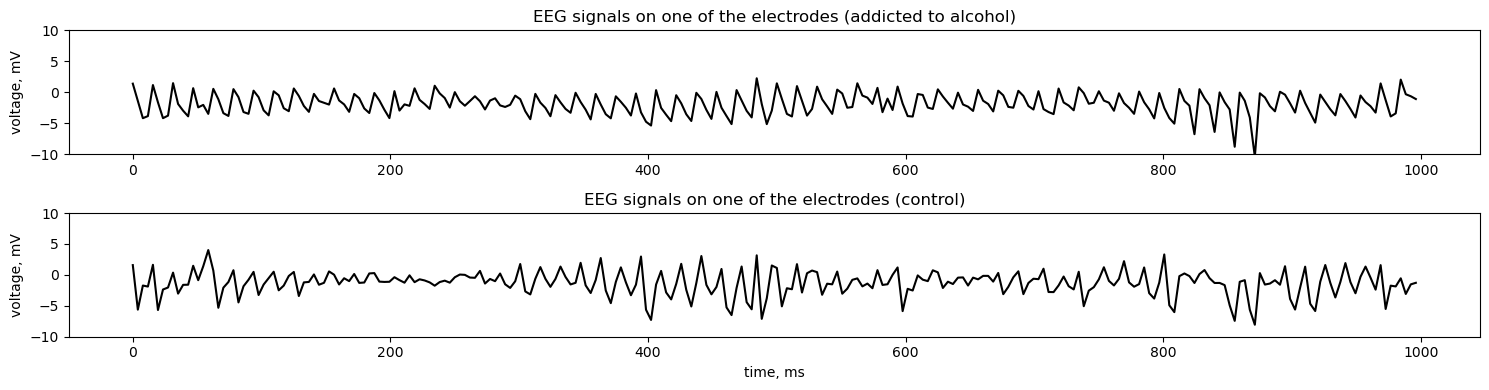

In [2]:
# processed_filename = 'dataset/smni_eeg.npz'
# df = np.load(processed_filename)
# data, labels = df['data'], df['labels']

# Nsubjects, Nchannels, Ntime, Nconditions = data.shape

# # For simplicity we will only use 1 condition out of 3 and take every second electrode
# data = data[:, ::2, :, 0]

# sample_frequency = 256 # Hz
# timepoints = 1000.0 * np.arange(Ntime) / sample_frequency # ms

# ind_alcohol = list(np.where(labels == 0)[0])[:10] #[:10] is to make tensor smaller
# ind_control = list(np.where(labels == 1)[0])[:10] #[:10] is to make tensor smaller

# fig, ax = plt.subplots(2, 1, figsize=(15, 4))

# ax[0].plot(timepoints, data[ind_alcohol[2], 4, :].T, color='k');
# ax[1].plot(timepoints, data[ind_control[2], 4, :].T, color='k');

# ax[1].set_xlabel('time, ms');
# ax[0].set_ylabel('voltage, mV');
# ax[1].set_ylabel('voltage, mV');
# ax[0].set_title('EEG signals on one of the electrodes (addicted to alcohol)');
# ax[1].set_title('EEG signals on one of the electrodes (control)');
# ax[0].set_ylim([-10, 10])
# ax[1].set_ylim([-10, 10])
# plt.tight_layout()

In [2]:
data_path = str(sample.data_path())
raw_fname = data_path + "/MEG/sample/sample_audvis_filt-0-40_raw.fif"
event_fname = data_path + "/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif"
tmin, tmax = -0.0, 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method="iir")  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info["bads"] = ["MEG 2443"]  # set bad channels
picks = mne.pick_types(
    raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads"
)

# Read epochs
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=False,
    picks=picks,
    baseline=None,
    preload=True,
    verbose=False,
)

labels = epochs.events[:, -1]
evoked = epochs.average()
data = epochs.get_data(copy=False)

D:\ANACONDA\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


In [3]:
n_objects, n_channels, n_time_measurements = data.shape
data.shape

(288, 60, 151)

In [4]:
labels.shape

(288,)

In [5]:
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.25, random_state = 123)
train_ids, test_ids = next(splitter.split(data, labels))

X_train, X_test = data[train_ids], data[test_ids]
y_train, y_test = labels[train_ids], labels[test_ids]

In [11]:
def euclidean_dist_adjacency(el_pos_3d: np.array) -> np.array:
    n_ch = len(el_pos_3d)
    dist_matrix = np.zeros((n_ch, n_ch))

    for i in range(n_ch):
        for j in range(i):
            dist_matrix[i][j] = 1 / np.linalg.norm(el_pos_3d[i] - el_pos_3d[j])

    dist_matrix += dist_matrix.T
    dist_matrix /= dist_matrix.max()
    return dist_matrix


def geodesic_dist_adjacency(el_pos_3d: np.array) -> np.array:
    el_pos_3d /= np.linalg.norm(el_pos_3d.astype(float), axis=1, keepdims=True)
    n_ch = len(el_pos_3d)
    dist_matrix = np.zeros((n_ch, n_ch))

    r = 1
    for i in range(n_ch):
        for j in range(i):
            dist_matrix[i][j] = 1 / (r * math.acos(round(np.dot(el_pos_3d[i], el_pos_3d[j]) / (r ** 2), 2)))

    dist_matrix += dist_matrix.T
    dist_matrix /= dist_matrix.max()
    return dist_matrix


def pearson_corr_adjacency(x):
    n_ch = x.shape[0]
    corr_matrix = np.zeros((n_ch, n_ch))
    for i in range(n_ch):
        for j in range(i):
            corr_matrix[i][j] = st.pearsonr(x[i, :], x[j, :])[0]
    corr_matrix += corr_matrix.T
    corr_matrix = np.abs(corr_matrix)
    return corr_matrix


def calculate_coherence(x, y, sf, low_freq, hi_freq):
    nperseg = (2 / low_freq) * sf
    freqs, coh = si.coherence(x, y, fs=sf, nperseg=nperseg)
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low_freq, freqs <= hi_freq)
    # Integral approximation of the coherence using Simpson's rule.
    bp = simps(coh[idx_band], dx=freq_res)
    return bp


def coherency_adjacency(x, sf, low_freq, hi_freq):
    n_ch = x.shape[0]
    coherence_matrix = np.zeros((n_ch, n_ch))
    for i in range(n_ch):
        for j in range(i):
            coherence_matrix[i][j] = calculate_coherence(x[i, :], x[j, :], sf, low_freq, hi_freq)
    coherence_matrix += coherence_matrix.T
    coherence_matrix /= coherence_matrix.max()
    return coherence_matrix


def calculate_plv(x, y):
    analytic_x = si.hilbert(x)
    analytic_y = si.hilbert(y)

    phase_x = np.unwrap(np.angle(analytic_x))
    phase_y = np.unwrap(np.angle(analytic_y))

    plv = np.mean([np.exp(1j*(phase_x - phase_y))])
    plv = np.sqrt(np.real(plv)**2 + np.imag(plv)**2)
    return plv


def plv_adjacency(x):
    n_ch = x.shape[0]
    plv_matrix = np.zeros((n_ch, n_ch))
    for i in range(n_ch):
        for j in range(i):
            plv_matrix[i][j] = calculate_plv(x[i, :], x[j, :])
    plv_matrix += plv_matrix.T
    return plv_matrix

def build_adjacencies(data, name, T):
    n_objects, n_channels, n_time_measurements = data.shape
    adjacencies = []
    for i in tqdm(range(n_objects)):
        for j in range(T, n_time_measurements):
            adj = pearson_corr_adjacency(data[i, :, (j-T):j])
            adjacencies.append(adj)
    adjacencies = np.array(adjacencies).reshape(n_objects, -1, n_channels, n_channels)
    print(adjacencies.shape)
    np.save(name, adjacencies)

In [12]:
T = 15

build_adjacencies(X_train, 'dataset/adj_Pears_{}_train_other.npy'.format(T), T)
build_adjacencies(X_test, 'dataset/adj_Pears_{}_test_other.npy'.format(T), T)

100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [54:01<00:00, 15.01s/it]


(216, 136, 60, 60)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [19:34<00:00, 16.31s/it]


(72, 136, 60, 60)


In [13]:
class GraphDataset(Dataset):
    @staticmethod
    def _get_edges(adjacencies, thr):
        edges = []
        for adj in adjacencies:
            edges_ = []
            for j in range(len(adj)):
                for i in range(j):
                    if adj[i][j] >= thr:
                        edges_.extend(([i, j], [j, i]))

            edges.append(np.array(edges_).T)

        return edges

#     @staticmethod
#     def _get_edge_weights(adjacencies, thr):
#         edge_weights = []
#         for adj in adjacencies:
#             edge_weights_ = []
#             for j in range(len(adj)):
#                 for i in range(j):
#                     if adj[i][j] >= thr:
#                         edge_weights_.extend((adj[i][j], adj[i][j]))

#             edge_weights.append(np.array(edge_weights_))
#         return edge_weights

    # @staticmethod
    # def _get_targets_and_features(x, y, drop_inx):
    #     # target_range = np.sort(np.unique(y))
    #     # targets = [np.where(i == target_range)[0] for i in y]
    #     # if drop_inx is not None:
    #     #     for i in drop_inx:
    #     #         x[:, i, :, :] = 0
    #     # features = [x[i].swapaxes(1, 2) for i in range(len(x))]
    #     targets = y
    #     features = x
    #     return targets, features

    
    
    def __init__(self, data, labels, T, adj_path, adj_thr, n_features = 5, shuffle = False, drop_inx=None):
        super().__init__()

        self.n_features = n_features
        self.n_objects, self.n_channels, self.n_time_measurements = data.shape
        self.T = T
        
        self.seq_len = self.n_time_measurements - T
        
        x = data
        y = labels
        
        self.relevant_time_measurements = self.n_time_measurements - T

        adjs = np.load(adj_path)
        
        if shuffle == True:
            x, y, adjs = shuffle(x, y, adjs, random_state=0)

            
        x = x.swapaxes(1, 2)
        # num_matrix = len(os.listdir(adj_path))
        # if num_matrix == 1:
        #     adjs = [np.load(adj_path+'matrix.npy')]*len(x)
        # else:
        #     adjs = [np.load(adj_path+f'matrix{i}.npy') for i in range(len(x))]
            
        adjs = adjs.reshape(-1, self.n_channels, self.n_channels)

        self.edges = self._get_edges(adjs, adj_thr)
        #self.edge_weights = self._get_edge_weights(adjs, adj_thr)
        #self.target, self.feature = self._get_targets_and_features(x, y, drop_inx)
        self.feature = x
        self.target = y

    def len(self):
#        return len(self.target)
        return self.n_objects*(self.n_time_measurements - self.T)


    def get(self, idx):
        
#         data_sequence = [Data(
#             x=torch.Tensor(self.feature[idx, :, (j+T - self.n_features):(j+T)]).reshape(-1, T),
#             edge_index=torch.LongTensor(self.edges[j + idx*self.relevant_time_measurements]),
#             #edge_attr=torch.Tensor(self.edge_weights[idx])
#         ) for j in range(self.relevant_time_measurements)]
        
#         target = torch.LongTensor(self.target[idx])
#         return data_sequence, target
        i = idx % (self.n_time_measurements - self.T)
        j = idx // (self.n_time_measurements - self.T)
        
        #print(self.feature[j, (i + self.T - self.n_features):(i + self.T + 1), :])
        #raise Exception('!')
        
        data_sequence = Data(
            x=torch.Tensor(self.feature[j, (i + self.T - self.n_features + 1):(i + self.T + 1), :]).T,
            edge_index=torch.LongTensor(self.edges[idx]),
            #edge_attr=torch.Tensor(self.edge_weights[idx])
        )
        target = torch.LongTensor([self.target[j]])

        return data_sequence, target

In [14]:
class GCN_LSTM(torch.nn.Module):
    def __init__(self, node_features, hidden_features, lstm_hidden_features, seq_len, output_dim, n_channels, \
                 fc_hidden = 32):
        super().__init__()
        
        self.hidden_features = hidden_features
        self.lstm_hidden_features = lstm_hidden_features
        self.new_n_ch = n_channels
        self.seq_len = seq_len
        
        self.conv1 = ChebConv(
            in_channels=node_features,
            out_channels=node_features,
            K=2,
            normalization="sym",
            bias=True
        )
        self.conv2 = ChebConv(
            in_channels=node_features,
            out_channels=self.hidden_features,
            K=2,
            normalization="sym",
            bias=True
        )
        # self.conv3 = ChebConv(
        #     in_channels=node_features,
        #     out_channels=1,
        #     K=2,
        #     normalization="sym",
        #     bias=True
        # )
        self.pool_ratio = 0.8
        self.pool1 = TopKPooling(node_features, ratio=self.pool_ratio)
        #self.pool2 = TopKPooling(node_features, ratio=self.pool_ratio)
        #self.new_n_ch = int(np.ceil(np.ceil(N_CH * self.pool_ratio) * self.pool_ratio))

        self.lstm1 = nn.LSTM(
            self.new_n_ch * self.hidden_features,
            lstm_hidden_features, #64,
            bidirectional=False,
            num_layers=1,
            batch_first=True
        )
        # self.lstm2 = nn.LSTM(
        #     32, #64,
        #     64, #128,
        #     bidirectional=False,
        #     num_layers=1,
        #     batch_first=True
        # )
        # self.lstm3 = nn.LSTM(
        #     64,
        #     128,
        #     bidirectional=False,
        #     num_layers=1,
        #     batch_first=True
        # )

        #self.pool_size = 256

        #self.dropout0 = nn.Dropout(0.1)
        #self.dropout1 = nn.Dropout(0.25)
        #self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(seq_len*lstm_hidden_features, fc_hidden)
        #self.linear1 = nn.Linear(seq_len * 256, 256)
        #self.linear1 = nn.Linear(self.pool_size * 256, 256)
        #self.linear2 = nn.Linear(256, 128)
        #self.linear3 = nn.Linear(128, 64)
        self.linear4 = nn.Linear(fc_hidden, output_dim)
        



    # -> x.shape = N*KxFxT
    def forward(self, x, edge_index, edge_weight, batch):
        
        # x_conv = []
        # for t in range(x.shape[-1]):
        #     x_t = self.conv1(x[..., t], edge_index, edge_weight, batch)
        #     x_t = F.leaky_relu(x_t)
        #     #x_t, edge_index_, edge_weight_, batch_, _, _ = self.pool1(x_t, edge_index, edge_weight, batch)
        #     x_t = self.conv2(x_t, edge_index, edge_weight, batch)
        #     #x_t, edge_index_, edge_weight_, batch_, _, _ = self.pool2(x_t, edge_index_, edge_weight_, batch_)
        #     #x_t = self.conv3(x_t, edge_index_, edge_weight_, batch_)
        #     x_conv.append(x_t.unsqueeze(-1))
        x_t = self.conv1(x, edge_index, edge_weight, batch)
        x_t = F.leaky_relu(x_t)
        #x_t, edge_index_, edge_weight_, batch_, _, _ = self.pool1(x_t, edge_index, edge_weight, batch)
        x_t = self.conv2(x_t, edge_index, edge_weight, batch)
        #x_t, edge_index_, edge_weight_, batch_, _, _ = self.pool2(x_t, edge_index_, edge_weight_, batch_)
        #x_t = self.conv3(x_t, edge_index_, edge_weight_, batch_)
        
        x_t = x_t.reshape(1, -1, self.new_n_ch, self.hidden_features).reshape(1, -1, self.new_n_ch*self.hidden_features)
        #x_t = x_t.reshape(1, self.hidden_dim, -1, self.n_features).swapaxes(1, 2).reshape(1, -1, self.hidden_dim*self.n_features)

        # # -> x_conv.shape = N*KxFxT
        # x_conv = torch.cat(x_conv, -1)
        # x_conv = x_conv.reshape(-1, self.new_n_ch, x_conv.shape[1], x_conv.shape[2])
        # #x_conv = x_conv.transpose(1, 2).transpose(2, 3).transpose(1, 2)
        # x_conv = x_conv.transpose(2, 3).transpose(1, 2)
        # #x_conv = x_conv.reshape(x_conv.shape[0], -1, self.new_n_ch)
        # x_conv = x_conv.reshape(x_conv.shape[0], x_conv.shape[1], -1)
        # #x_conv = self.dropout0(x_conv)

        # -> x_conv.shape = NxF*TxK
        x_lstm, _ = self.lstm1(x_t)
        
        x_lstm = self.dropout3(x_lstm)
        #x_lstm, _ = self.lstm2(x_lstm)
        #x_lstm = self.dropout2(x_lstm)
        #x_lstm, _ = self.lstm3(x_lstm)

        #x_lstm = x_lstm.transpose(1, 2)
        #x_lstm = F.adaptive_max_pool1d(x_lstm, output_size=self.pool_size).transpose(1, 2)
        #x_lstm = self.dropout3(x_lstm)
        
        #print(x_lstm.shape)

        x_lin = torch.flatten(x_lstm, 1)
        #x_lin = x_lstm[:, -1, :]
        
        x_lin = F.relu(self.linear1(x_lin))
        x_lin = self.dropout3(x_lin)
        #x_lin = F.relu(self.linear2(x_lin))
        #x_lin = self.dropout3(x_lin)
        #x_lin = F.relu(self.linear3(x_lin))
        x_lin = self.linear4(x_lin)
        return x_lin

In [15]:
def train(train_loader, model, optimizer, criterion, device, tqdm_disable=False):
    model.train()
    y_true, y_pred = [], []
    loss = 0
    n_train = len(train_loader)
    for batch in tqdm(train_loader, total=n_train, disable=tqdm_disable):
        data, target = batch
        
        data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss_ = criterion(out, target[0].to(device))
        
        
        loss_.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss += loss_.detach().cpu().item()
        y_true.append(target[0].detach().cpu().numpy())
        y_pred.append(out.detach().cpu().argmax(1).numpy())

    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)

    loss /= n_train
    acc = (y_true == y_pred).mean()
    f1 = f1_score(y_true, y_pred, average='macro')
    return loss, acc, f1


def test(test_loader, model, criterion, device):
    model.eval()
    y_true, y_pred = [], []
    loss = 0
    n_test = len(test_loader)
    with torch.no_grad():
        for batch in test_loader:
            data, target = batch
            data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss_ = criterion(out, target[0].to(device))
            
            loss += loss_.detach().cpu().item()
            y_true.append(target[0].detach().cpu().numpy())
            y_pred.append(out.detach().cpu().argmax(1).numpy())

    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)

    loss /= n_test
    acc = (y_true == y_pred).mean()
    f1 = f1_score(y_true, y_pred, average='macro')
    return loss, acc, f1

In [16]:
def plot_training_curves(train_arr, test_arr, T, save = True):
    
    n_epochs = train_arr.shape[1]
    x = np.arange(1, n_epochs + 1)
    
    plt.figure(figsize = (8, 8))
    
    plt.plot(x, train_arr.mean(axis = 0), color = 'b', label = 'train')
    plt.fill_between(x, train_arr.mean(axis = 0) - train_arr.std(axis = 0),\
                                  train_arr.mean(axis = 0) + train_arr.std(axis = 0), color = 'b', alpha = 0.5)
               
    plt.plot(x, test_arr.mean(axis = 0), color = 'g', label = 'test')
    plt.fill_between(x, test_arr.mean(axis = 0) - test_arr.std(axis = 0), test_arr.mean(axis = 0) + test_arr.std(axis = 0), color = 'g', alpha = 0.5)
    
    plt.legend(loc = 'best')
    if save == True:
        plt.savefig('figures/t{}.png'.format(T))
    
    plt.xlabel('номер эпохи')
    plt.ylabel('кросс-энтропия')
    
    plt.show()

In [20]:
n_objects, n_channels, n_time_measurements = data.shape

def conduct_experiment(T, n_hidden = 5, num_epochs = 30, lr = 1e-4):
    NF = 5
    SEQ_LEN = n_time_measurements - T
    N_HIDDEN_LSTM = 8
    N_CH = 60
    N_CLASSES = 4
    
    batch_size = SEQ_LEN

    train_dataset = GraphDataset(X_train, y_train, T = T, adj_path = 'dataset/adj_Pears_{}_train_other.npy'.format(T), adj_thr = 0.8)
    test_dataset = GraphDataset(X_test, y_test, T = T, adj_path = 'dataset/adj_Pears_{}_test_other.npy'.format(T), adj_thr = 0.8)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    best_acc = 0
    best_f1_score = 0

    train_losses_arrays = []
    test_losses_arrays = []
    
    device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

    #seed_torch()
    # decay, no_decay = [], []
    # for name, param in model.named_parameters():
    #     if 'conv1.lins' in name:
    #         decay.append(param)
    #     else:
    #         no_decay.append(param)

    #optimizer = torch.optim.Adam([
    #    {'params': no_decay, 'weight_decay': 0}, {'params': decay, 'weight_decay': 5e-4}
    #], lr=args.lr)


    #train_loader, test_loader = get_loaders(**json.loads(args.data_config), batch_size=args.bs, shuffle=True)

    print('\n===================================================================================\n')
    for j in range(3):
        
        model = GCN_LSTM(node_features=NF, hidden_features = n_hidden, lstm_hidden_features = N_HIDDEN_LSTM, \
                         seq_len=SEQ_LEN, output_dim=N_CLASSES, n_channels = N_CH)
        model.to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss().to(device)
        
        train_losses_array = []
        test_losses_array = []

        for epoch in range(1, num_epochs + 1):
            loss, acc, f1 = train(train_loader, model, optimizer, criterion, device)
            train_losses_array.append(loss)
            print(f'TRAIN: epoch = {epoch}, loss = {round(loss, 3)}, accuracy = {round(acc, 3)}, f1 = {round(f1, 3)}')
            loss, acc, f1 = test(test_loader, model, criterion, device)

            if acc > best_acc:
                best_acc = acc
            if f1 > best_f1_score:
                best_f1_score = f1

            test_losses_array.append(loss)
            print(f'TEST: loss = {round(loss, 3)}, accuracy = {round(acc, 3)}, f1 = {round(f1, 3)}')
            print('-' * 50)
            # if epoch == NUM_EPOCHS:
            #     torch.save(model.state_dict(), f"models/seed_pearson_gcn_lstm_epoch_60_lr_1e-4.pth")

        train_losses_arrays.append(train_losses_array)
        test_losses_arrays.append(test_losses_array)
        print('\n===================================================================================\n')

    train_losses_arrays = np.array(train_losses_arrays)
    test_losses_arrays = np.array(test_losses_arrays)

    return best_acc, best_f1_score, train_losses_arrays, test_losses_arrays

In [18]:
# best_f1_scores = []
# best_accs = []

In [19]:
# T = 5

# build_adjacencies(X_train, 'dataset/adj_Pears_{}_train.npy'.format(T), T)
# build_adjacencies(X_test, 'dataset/adj_Pears_{}_test.npy'.format(T), T)

In [22]:
T = 15

best_acc, best_f1_score, train_losses_arrays, test_losses_arrays = conduct_experiment(T = T, num_epochs = 15, lr = 5e-5)

  7%|█████▋                                                                           | 15/216 [00:07<01:41,  1.98it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


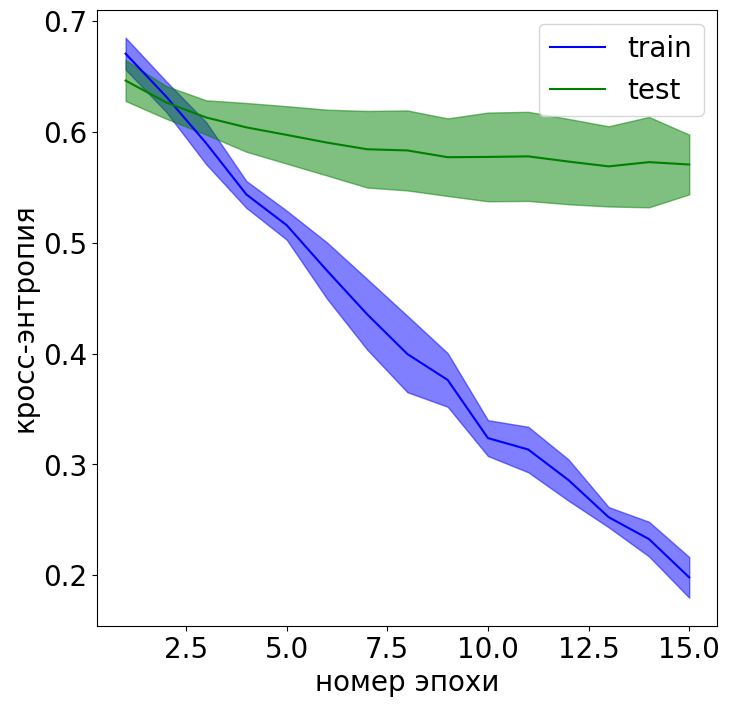

0.7619047619047619 0.8


In [108]:
plot_training_curves(train_losses_arrays, test_losses_arrays, T = 5, save = True)
print(best_f1_score, best_acc)
best_f1_scores.append(best_f1_score)
best_accs.append(best_acc)

In [101]:
best_f1_scores

[0.7619047619047619, 0.7619047619047619, 0.7]

In [109]:
best_f1_scores

[0.7619047619047619,
 0.7619047619047619,
 0.7,
 0.6590909090909092,
 0.7619047619047619]

In [110]:
best_accs

[0.8, 0.8, 0.7333333333333333, 0.7333333333333333, 0.8]

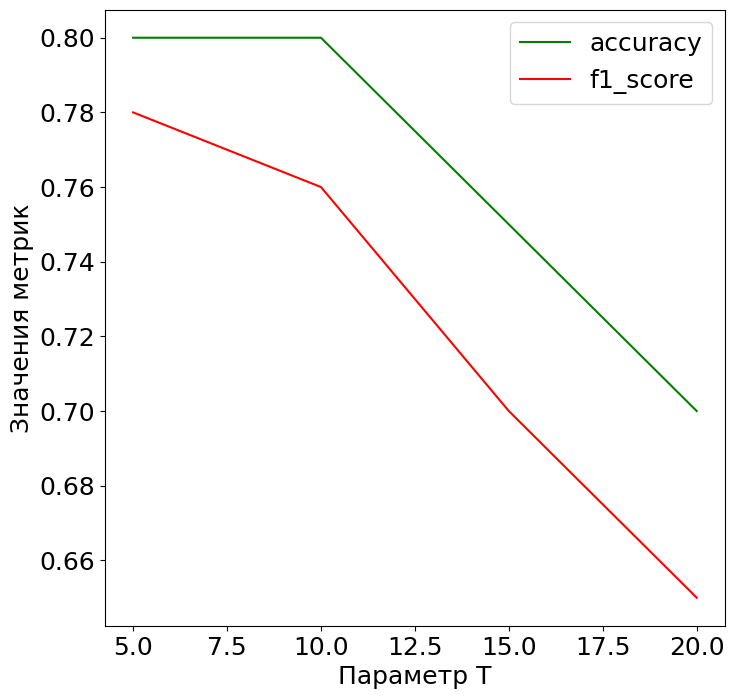

In [117]:
plt.figure(figsize = (8,8))

best_f1_scores = np.array([0.78, 0.76, 0.7, 0.65])
best_accs = np.array([0.8, 0.8, 0.75, 0.7])
T_array = np.array([5, 10, 15, 20])

plt.plot(T_array, best_accs, label = 'accuracy', color = 'g')
plt.plot(T_array, best_f1_scores, label = 'f1_score', color = 'r')

plt.xlabel('Параметр T')
plt.ylabel('Значения метрик')
plt.legend(loc = 'best')
plt.savefig('figures/final_res.png')
plt.show()